In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from datetime import datetime

## Covid Data

Received data from [The Covid Tracking Project API](https://covidtracking.com/data/api), which separates and aggregates data across states with many helpful features. From this data, we can generate our metric of `positivityRate`, which we'll calculate as `positive` / `totalTestResults`

In [168]:
style.use('fivethirtyeight')

In [2]:
covid_df = pd.read_csv('https://api.covidtracking.com/v1/states/daily.csv')

In [12]:
covid_df.to_csv('./data/covid_data_per_state.csv')

In [13]:
covid_df['positivityRate'] = covid_df['positive'] / covid_df['totalTestResults']

In [14]:
covid_df.isnull().sum() / covid_df.shape[0] # Showing percentage of nulls

date                           0.000000
state                          0.000000
positive                       0.009172
negative                       0.021957
pending                        0.883361
hospitalizedCurrently          0.258662
hospitalizedCumulative         0.440800
inIcuCurrently                 0.591810
inIcuCumulative                0.842412
onVentilatorCurrently          0.652585
onVentilatorCumulative         0.944599
recovered                      0.333889
dataQualityGrade               0.109505
lastUpdateEt                   0.039281
dateModified                   0.039281
checkTimeEt                    0.039281
death                          0.069390
hospitalized                   0.440800
dateChecked                    0.039281
totalTestsViral                0.434593
positiveTestsViral             0.798962
negativeTestsViral             0.844914
positiveCasesViral             0.271540
deathConfirmed                 0.619881
deathProbable                  0.733926


The reason there are so many nulls in certain columns are that The Covid Tracking Project **rendered some of those features deprecated in more recent versions of the dataset**. We won't use any of the deprecated features in our analysis

In [15]:
covid_df['datetime'] = pd.to_datetime(covid_df['date'], format=('%Y%m%d'))

In [16]:
covid_df['positivityRate'].value_counts()

0.000000    250
1.000000    112
0.003651     10
0.215385      9
0.003672      9
           ... 
0.188767      1
0.113556      1
0.098316      1
0.074140      1
0.041648      1
Name: positivityRate, Length: 9755, dtype: int64

In [151]:
# soi = states of interest
covid_df_soi = covid_df[covid_df['state'].isin(['IL', 'TX', 'GA', 'FL', 'NJ', 'NY', 'MI', 'OH'])]

### Removing unhelpful data from states

Some states had 100% positivity rate before they started testing regularly, we're removing those dates from these states below

In [152]:
covid_df_soi.loc[covid_df_soi['state'] == 'NJ', :] = covid_df_soi.loc[covid_df_soi['date'] > 20200324, :]

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [153]:
covid_df_soi.loc[covid_df_soi['state'] == 'OH', :] = covid_df_soi.loc[covid_df_soi['date'] > 20200324, :]

In [159]:
covid_df_soi.loc[covid_df_soi['state'] == 'FL', :] = covid_df_soi.loc[covid_df_soi['date'] > 20200320, :]

### Cleaning `covid_df_soi`

`covid_df_soi` = covid dataframe states of interest

In [317]:
covid_df_soi = covid_df_soi[['date', 'datetime', 'state', 'positivityRate', 'hospitalizedIncrease', 'deathIncrease', 'recovered']]

In [318]:
covid_df_soi = covid_df_soi[covid_df_soi['date'] > 20200317]

In [319]:
covid_df_soi.dropna(subset=['positivityRate'], inplace=True)

### Getting positivity rate at shutdown announcement date

In [320]:
shutdown_date_df = pd.DataFrame(columns=['positivityRateShutdown', 'positivityRateReopen', 'date_shutdown_announced', 'date_bars_reopen'], index=covid_df_soi.state.unique())

In [322]:
def find_shutdown_date(state:str, dates:list):
    shutdown_date_df.loc[state, ['positivityRateShutdown', 'date_shutdown_announced']] = [covid_df.loc[((covid_df['date'] == dates[0]) & 
                                                                                (covid_df['state'] == state)), 
                                                                                'positivityRate'].values[0], 
                                                                                # Converting items in list to datetime
                                                                                pd.to_datetime(dates[0], format='%Y%m%d')]
    
    shutdown_date_df.loc[state, ['positivityRateReopen', 'date_bars_reopen']] = [covid_df.loc[((covid_df['date'] == dates[1]) & 
                                                                            (covid_df['state'] == state)), 
                                                                            'positivityRate'].values[0], 
                                                                            # Converting items in list to datetime
                                                                            pd.to_datetime(dates[1], format='%Y%m%d')]
    
                                                                                  
                                                     

In [327]:
timeline_dict = {
    'FL': [20200401, 20200605],
    'TX': [20200331, 20200518],
    'NJ': [20200316, 20200609],
    'NY': [20200322, 20200613],
    'IL': [20200320, 20200529],
    'GA': [20200402, 20200601],
    'OH': [20200322, 20200526],
    'MI': [20200323, 20200608]
}

In [328]:
for state, date in timeline_dict.items():
    find_shutdown_date(state, date)

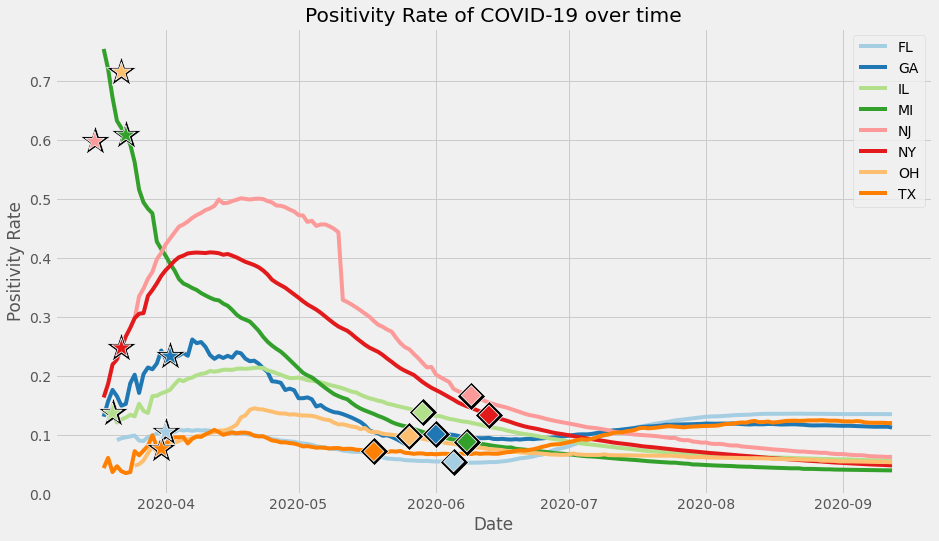

In [331]:
plt.figure(figsize=(14,8))

# Start date markers
sns.scatterplot(data=shutdown_date_df, 
                x="date_shutdown_announced", 
                y="positivityRateShutdown",
                marker="*", 
                s=1000, 
                color='black',
               legend=False,
               zorder=3)
sns.scatterplot(data=shutdown_date_df, 
                x="date_shutdown_announced", 
                y="positivityRateShutdown",
                marker="*", 
                s=400, 
                hue=shutdown_date_df.index,
                palette='Paired',
               legend=False,
               zorder=3)

# Bar reopening date markers
sns.scatterplot(data=shutdown_date_df, 
                x="date_bars_reopen", 
                y="positivityRateReopen",
                marker="D", 
                s=400, 
                color='black',
               legend=False,
               zorder=3)
sns.scatterplot(data=shutdown_date_df, 
                x="date_bars_reopen", 
                y="positivityRateReopen",
                marker="D", 
                s=200, 
                hue=shutdown_date_df.index,
                palette='Paired',
               legend=False,
               zorder=3)

sns.lineplot(data=covid_df_soi, 
             x='datetime', 
             y='positivityRate', 
             hue=covid_df_soi['state'].tolist(),
            palette='Paired')
plt.title('Positivity Rate of COVID-19 over time')
plt.xlabel('Date')
plt.ylabel('Positivity Rate');

**Stars** = Start date announced  
**Diamonds** = Reopening date announced

*Note the stars on this plot not connected to lines belong to NJ and OH. These states had positivity rates that did not represent the natural trend at the onset of their Covid shutdown.*

#### Insights: 
* States allowed bars to reopen within a month window around the beginning of June
* States whose **positivity rates went down** after reopening bars include: OH, NY, IL, MI, and NJ
* States whose **positivity rates went up** after reopening include: TX, FL, and GA
* There was large drop in positivity rate after a spike in New Jersey test results being added to the dataset around May 10


Future steps - Some states had second shutdowns after reopening, we'd like to look at when those dates occured and add them to the visual


In [345]:
nj_tests = covid_df[covid_df['state'] == 'NJ'][['totalTestResultsIncrease', 'state', 'datetime']]

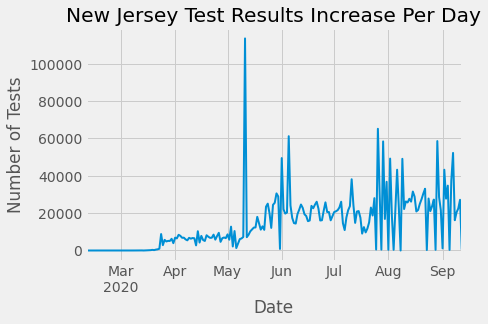

In [352]:
nj_tests.plot(x='datetime', y='totalTestResultsIncrease', legend=False, linewidth=2)
plt.title('New Jersey Test Results Increase Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Tests');